In [1]:
import sys
sys.path.append('..')

from scripts.GenrationGI0 import partitioned_gi0_image, generate_multiple_images, mixed_dataset
from scripts.autoencoders import InMemoryImageDataset, ConfigurableAutoencoder

import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import cv2
from omegaconf import OmegaConf

In [2]:
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    pass

Elegir el archivo de configuración correspondiente:

In [3]:
config_name = 'config_simetrico-lr0_001-short_train' # Elegir

config_path = f'configs/{config_name}.yaml'
config = OmegaConf.load(config_path)
config

{'training': {'n': 50000, 'n_cuad_lado': [2], 'pixeles_cuad': [25], 'ratio': [1], 'num_epochs': 70, 'batch_size': 64, 'learning_rate': 0.001, 'scheduler_name': 'None', 'scheduler_params': 'None'}, 'model': {'encoding_dim': 32, 'loss_function': 'mse', 'optimizer': 'adam'}, 'encoder': {'layers': [{'type': 'conv2d', 'filters': 16, 'kernel_size': 3, 'stride': 2, 'padding': 1, 'activation': 'relu'}, {'type': 'flatten'}, {'type': 'dense', 'dim': '${model.encoding_dim}', 'activation': 'relu'}]}, 'decoder': {'layers': [{'type': 'dense', 'dim': 10000, 'activation': 'relu'}, {'type': 'unflatten', 'dim1': 25, 'dim2': 25, 'out_channels': 16}, {'type': 'conv2d_transpose', 'filters': 1, 'kernel_size': 2, 'stride': 2, 'padding': 0, 'activation': 'sigmoid'}]}, 'testing': {'n': 1000, 'batch_size': 32}}

---
# Creación del dataset para entrenar

In [4]:
n = config['training']['n']
n_cuad_lado = config['training']['n_cuad_lado']
pixeles_cuad = config['training']['pixeles_cuad']
batch_size = config['training']['batch_size']

In [5]:
train_g, train_gi, train_gI0 = mixed_dataset(
    n_total = n,
    generate_multiple_images = generate_multiple_images,
    conjunto_n_cuad_lado = n_cuad_lado,
    conjunto_pixeles_cuad = pixeles_cuad,
    ratios = config.training.get('ratio',[1]),
)

In [6]:
normalize_to_01 = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_to_01
])

dataset_train = InMemoryImageDataset(train_gI0, train_gi, transform=transform)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

---
# Entrenamiento

In [7]:
num_epochs = config['training']['num_epochs']
learning_rate = config['training']['learning_rate']
scheduler_name = config['training']['scheduler_name']

In [8]:
autoencoder = ConfigurableAutoencoder(config=config)
autoencoder

ConfigurableAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=10000, out_features=32, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=10000, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(16, 25, 25))
    (3): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (4): Sigmoid()
  )
)

In [9]:
ncl = n_cuad_lado[0]
pc = pixeles_cuad[0]

summary(
    autoencoder,
    (1, ncl*pc, ncl*pc) # (nro_de_canales, alto, ancho) de las imágenes de entrada
)
# El -1 que se ve en la primera posición de todos los output shapes es un placeholder para el tamaño del batch

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 25, 25]             160
              ReLU-2           [-1, 16, 25, 25]               0
           Flatten-3                [-1, 10000]               0
            Linear-4                   [-1, 32]         320,032
              ReLU-5                   [-1, 32]               0
            Linear-6                [-1, 10000]         330,000
              ReLU-7                [-1, 10000]               0
         Unflatten-8           [-1, 16, 25, 25]               0
   ConvTranspose2d-9            [-1, 1, 50, 50]              65
          Sigmoid-10            [-1, 1, 50, 50]               0
Total params: 650,257
Trainable params: 650,257
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.50
Params size (MB): 2.48
Estimated T

In [10]:
loss = config['model']['loss_function'].lower()
opt = config['model']['optimizer'].lower()

if loss == 'mse':
    criterion = nn.MSELoss()
elif loss == 'bce':
    criterion = nn.BCELoss()

if opt == 'adam':
    optimizer = optim.Adam(
        autoencoder.parameters(), 
        lr=learning_rate
    )
elif optim == 'sgd':
    optimizer = optim.SGD(
        autoencoder.parameters(), 
        lr=learning_rate,
        momentum=0.9
    )

In [11]:
if scheduler_name is None:
    pass

elif scheduler_name.lower() == "rlrop":
    # ReduceLROnPlateau - reduce el lr cuando el loss deja de mejorar
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode=config.training.scheduler_params.get('mode','min'),
        factor=config.training.scheduler_params.get('factor',0.1),   # Reduce el lr por este factor
        patience=config.training.scheduler_params.get('patience',5)  # Espera estas épocas antes de reducir
    )

elif scheduler_name.lower() == "slr":
    # StepLR - reduce el lr cada cierto número de épocas
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=config.training.scheduler_params.get('step_size',7),  # Cada step_size épocas
        gamma=config.training.scheduler_params.get('gamma',0.1)         # Reduce por este factor
    )

elif scheduler_name.lower() == "elr":
    # ExponentialLR - reduce el lr exponencialmente
    scheduler = torch.optim.lr_scheduler.ExponentialLR(
        optimizer,
        gamma=config.training.scheduler_params.get('gamma',0.95)  # Factor de reducción por época
    )

In [12]:
training_losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    
    for data in train_loader:
        entrada, salida = data
        entrada = entrada.float()
        salida = salida.float()

        # Forward pass
        outputs = autoencoder(entrada) # Se pasa a las imágenes por el autoencoder, en una pasada forward.
        loss = criterion(outputs, salida) # Se calcula la diferencia entre el output y las imágenes sin ruido, según la función de pérdida definida.

        # Backward pass y optimización
        optimizer.zero_grad() # Se restablecen los gradientes acumulados en todos los parámetros del modelo.
                              # Esto es necesario antes de realizar el backward pass, ya que PyTorch acumula los gradientes en cada llamada a loss.backward().
        loss.backward() # Se realiza el backward pass para calcular los gradientes de los parámetros del autoencoder utilizando la función de pérdida.
        optimizer.step() # Finalmente se realiza la optimización de los parámetros del modelo mediante la llamada a optimizer.step(), que actualiza los parámetros en función de los gradientes calculados.

        epoch_losses.append(loss.item())
        
    avg_loss = np.mean(epoch_losses)
    training_losses.append(avg_loss)

    if scheduler_name is None:
        pass
    elif scheduler_name.lower() == "rlrop":
        scheduler.step(avg_loss)
        print(f"lr: {scheduler.get_last_lr()}")
    elif scheduler_name.lower() in ["slr", "elr"]:
        scheduler.step()
        print(f"lr: {scheduler.get_last_lr()}")
    
    # Imprimir la pérdida del autoencoder en cada época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/70], Loss: 0.0308
Epoch [2/70], Loss: 0.0041
Epoch [3/70], Loss: 0.0034
Epoch [4/70], Loss: 0.0033
Epoch [5/70], Loss: 0.0032
Epoch [6/70], Loss: 0.0031
Epoch [7/70], Loss: 0.0030
Epoch [8/70], Loss: 0.0030
Epoch [9/70], Loss: 0.0030
Epoch [10/70], Loss: 0.0030
Epoch [11/70], Loss: 0.0029
Epoch [12/70], Loss: 0.0029
Epoch [13/70], Loss: 0.0029
Epoch [14/70], Loss: 0.0029
Epoch [15/70], Loss: 0.0029
Epoch [16/70], Loss: 0.0029
Epoch [17/70], Loss: 0.0029
Epoch [18/70], Loss: 0.0029
Epoch [19/70], Loss: 0.0029
Epoch [20/70], Loss: 0.0029
Epoch [21/70], Loss: 0.0029
Epoch [22/70], Loss: 0.0029
Epoch [23/70], Loss: 0.0029
Epoch [24/70], Loss: 0.0029
Epoch [25/70], Loss: 0.0029
Epoch [26/70], Loss: 0.0029
Epoch [27/70], Loss: 0.0029
Epoch [28/70], Loss: 0.0029
Epoch [29/70], Loss: 0.0029
Epoch [30/70], Loss: 0.0029
Epoch [31/70], Loss: 0.0029
Epoch [32/70], Loss: 0.0029
Epoch [33/70], Loss: 0.0029
Epoch [34/70], Loss: 0.0029
Epoch [35/70], Loss: 0.0029
Epoch [36/70], Loss: 0.0029
E

In [13]:
# Guardo los parámetros del modelo entrenado:
torch.save(autoencoder.state_dict(), f'data/trained_models/{config_name}.pth')

In [14]:
"""
### Cuando quiera, en otro notebook, levantar el modelo guardado para usarlo para predecir, hay que hacer esto:

# 1. Crear una instancia del modelo (debe tener la misma arquitectura)
autoencoder_cargado = ConfigurableAutoencoder(config=config)
# 2. Carga los parámetros
autoencoder_cargado.load_state_dict(torch.load(f'data/trained_models/{config_name}.pth'))
# 3. Modo evaluación (cuando lo use para inferencia)
autoencoder_cargado.eval()
"""

"\n### Cuando quiera, en otro notebook, levantar el modelo guardado para usarlo para predecir, hay que hacer esto:\n\n# 1. Crear una instancia del modelo (debe tener la misma arquitectura)\nautoencoder_cargado = ConfigurableAutoencoder(config=config)\n# 2. Carga los parámetros\nautoencoder_cargado.load_state_dict(torch.load(f'data/trained_models/{config_name}.pth'))\n# 3. Modo evaluación (cuando lo use para inferencia)\nautoencoder_cargado.eval()\n"

In [15]:
df_errors = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'loss': training_losses
})

df_errors.to_csv(f'data/train_errors/{config_name}.csv', index=False)

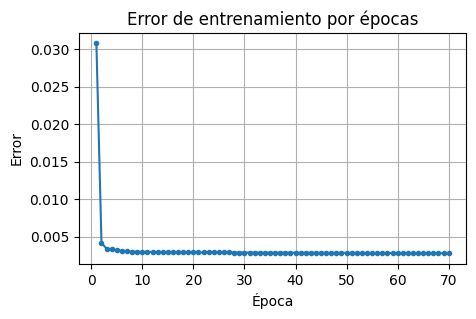

In [16]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs + 1), training_losses, '.-')
plt.title('Error de entrenamiento por épocas')
plt.xlabel('Época')
plt.ylabel('Error')
plt.grid()

---
# Evaluación

In [17]:
autoencoder.eval() # Para desactivar Dropout, BatchNorm, etc.
n = config['testing']['n']
batch_size = config['testing']['batch_size']

In [18]:
test_g, test_gi, test_gI0 = mixed_dataset(
    n_total = n,
    generate_multiple_images = generate_multiple_images,
    conjunto_n_cuad_lado = n_cuad_lado,
    conjunto_pixeles_cuad = pixeles_cuad,
    ratios = config.training.get('ratio',[1]),
)

In [19]:
dataset_test = InMemoryImageDataset(test_gI0, test_gi, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [20]:
total_loss = 0
with torch.no_grad(): # Esto es para asegurarse de que no se realicen cálculos de gradientes durante la evaluación del autoencoder.
                      # Al entrar en este bloque, se desactiva el cálculo y almacenamiento automático de gradientes para reducir el uso de memoria y acelerar la evaluación.
    for data in test_loader:
        entrada, salida = data
        entrada = entrada.float()
        salida = salida.float()

        # Forward pass
        outputs = autoencoder(entrada) # Se realiza el forward pass del autoencoder con las imágenes de prueba.
                                       # El autoencoder genera las imágenes reconstruidas utilizando el método forward() que definimos previamente en la clase Autoencoder.
        loss = criterion(outputs, salida) # Se calcula la pérdida entre las imágenes reconstruidas y las imágenes originales utilizando la función de pérdida (criterion).
                                          # Esto proporciona una medida de cuánto difieren las imágenes reconstruidas de las originales.
        total_loss += loss.item() # La pérdida obtenida en cada iteración se suma a la variable total_loss utilizando loss.item(), que devuelve el valor escalar de la pérdida.
                                  # Al final de la iteración, total_loss contendrá la suma acumulada de las pérdidas de todas las muestras del conjunto de datos de prueba.

average_loss = total_loss / len(test_loader) # Se calcula la pérdida promedio dividiendo la suma acumulada de las pérdidas (total_loss) entre el número de lotes en el conjunto de datos de prueba (len(test_loader)).
                                             # Esto proporciona una medida promedio de la discrepancia entre las imágenes originales y las imágenes reconstruidas por el autoencoder en el conjunto de datos de prueba.
print(f"Average Test Loss: {average_loss:.4f}")

Average Test Loss: 0.0029


In [21]:
test_file_path = f'data/test_errors.csv'

new_result = pd.DataFrame({
    'config_name': [config_name],
    'loss_testing': [average_loss]
})

try:
    existing_results = pd.read_csv(test_file_path)
    existing_results = existing_results[existing_results['config_name'] != config_name]
    all_results = pd.concat([existing_results, new_result], ignore_index=True)
except FileNotFoundError:
    all_results = new_result

all_results.to_csv(test_file_path, index=False)

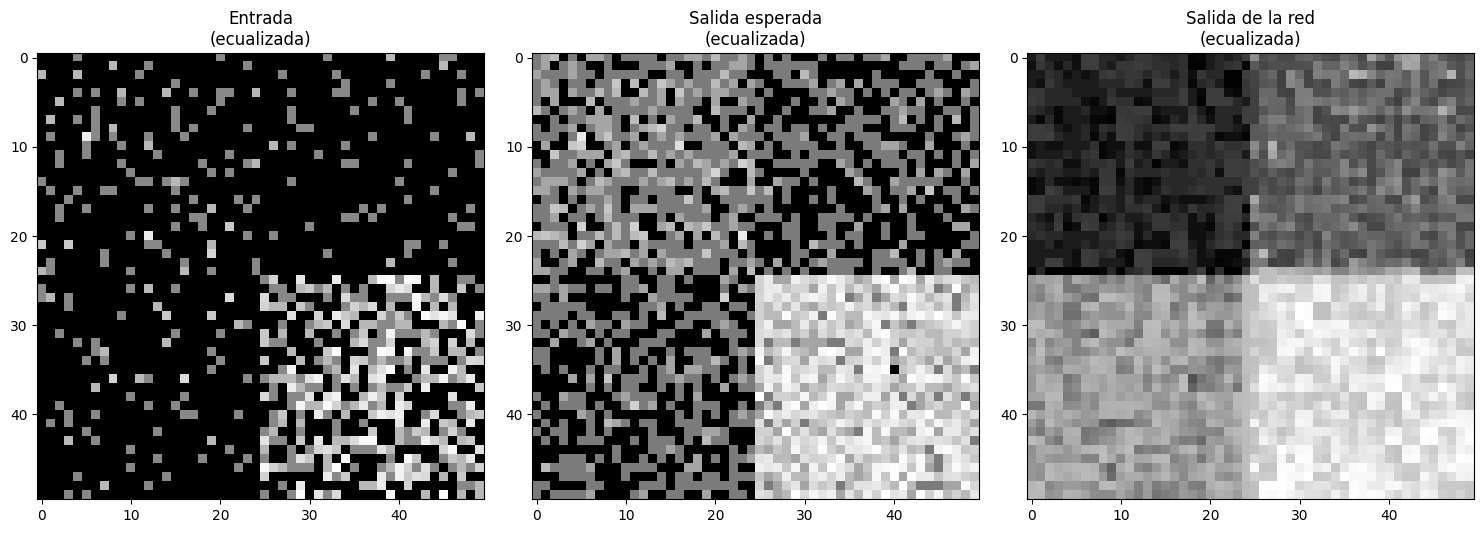

In [22]:
# Aplico el autoencoder a un ejemplo particular del dataset de testeo y veo cómo queda la
# imagen de salida.

ecualizar_hist = True  # Si se quiere o no ecualizar el histograma de la imagen

###

def graph_random_image(ecualizar_hist, name_suffix, show_plot=True):

    index = int(n*np.random.random()) # Índice del ejemplo puntual que se desea seleccionar
    entrada_red, salida_red = dataset_test[index]

    example = entrada_red.float().unsqueeze(0)

    reconstructed = autoencoder(example) # Aplica el autoencoder al ejemplo

    tamanio = ncl*pc

    entrada = entrada_red.view(tamanio, tamanio)
    salida_esperada = salida_red.view(tamanio, tamanio)
    reconstructed = reconstructed.view(tamanio, tamanio)

    imagenes = [entrada, salida_esperada, reconstructed.detach()]
    titulos = ['Entrada', 'Salida esperada', 'Salida de la red']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, imagen, titulo in zip(axes, imagenes, titulos):
        if ecualizar_hist:
            im = imagen.cpu().numpy()
            im = ((im - im.min()) * 255) / (im.max() - im.min())
            imagen = cv2.equalizeHist(im.astype(np.uint8))
            titulo += '\n(ecualizada)'
        
        ax.imshow(imagen, cmap='gray')
        ax.set_title(titulo)

    plt.tight_layout()
    plt.savefig(f'data/images/{config_name}_{name_suffix}.png', dpi=300, bbox_inches='tight')

    if not show_plot:
        plt.close(fig)

    return imagenes, titulos

imagenes, titulos = graph_random_image(ecualizar_hist=ecualizar_hist, name_suffix=1, show_plot=True)

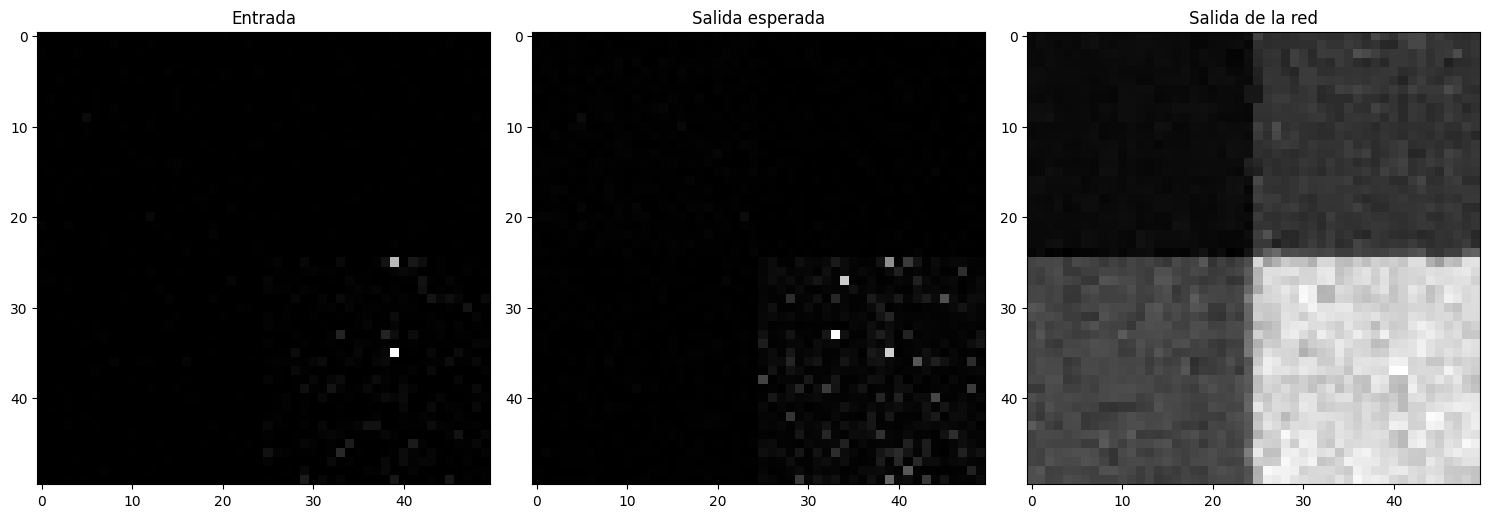

In [23]:
# Hago lo mismo que arriba, para la misma imagen, pero sin ecualizar

ecualizar_hist = False  # Si se quiere o no ecualizar el histograma de la imagen

###

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, imagen, titulo in zip(axes, imagenes, titulos):
    if ecualizar_hist:
        im = imagen.cpu().numpy()
        im = ((im - im.min()) * 255) / (im.max() - im.min())
        imagen = cv2.equalizeHist(im.astype(np.uint8))
        titulo += '\n(ecualizada)'
    
    ax.imshow(imagen, cmap='gray')
    ax.set_title(titulo)

plt.tight_layout()

In [24]:
# Guardo otra imagen solo para tener a modo de ejemplo
imagenes, titulos = graph_random_image(ecualizar_hist=True, name_suffix=2, show_plot=False)